# OOD Detection Pipeline

## 1. Load data to obtain hidden representations.

### Datasets

In [1]:
from constants.data_constants import JORDAN_DATASET_FILEPATH, MAESTRO_DATASET_FILEPATH
from data.jordan_dataset import JordanDataset
from data.maestro_dataset import MaestroDataset


print("Loading Jordan dataset - train")
id_train_base_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="train",
    name="id_train_base_dataset"
)
print(f"Obtained {len(id_train_base_dataset)} training examples from Jordan dataset - train")

print("Loading Jordan dataset - test")
id_test_base_dataset = JordanDataset(
    data_dir=JORDAN_DATASET_FILEPATH,
    split="validation",
    name="id_test_base_dataset",
    num_samples=80
)
print(f"Obtained {len(id_test_base_dataset)} testing examples from Jordan dataset - test")

print("Loading Maestro dataset - test")
ood_base_dataset = MaestroDataset(
    data_dir=MAESTRO_DATASET_FILEPATH,
    split="test",
    name="maestro_test_base_dataset",
    num_samples=80
)
print(f"Obtained {len(ood_base_dataset)} testing examples from Maestro dataset - test")

/data/scratch/joeltjy1/conda_envs/ood-detection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Jordan dataset - train
Sample tokens:
Detected 0 bad samples
Obtained 4550 training examples from Jordan dataset - train
Loading Jordan dataset - test
Sample tokens:
Detected 0 bad samples
Obtained 80 testing examples from Jordan dataset - test
Loading Maestro dataset - test
Obtained 80 testing examples from Maestro dataset - test


From each data sample in each of these datasets, extract all sliding windows of length SLIDING_WINDOW_LEN = 120 tokens (=40 events). This can be configured in constants/real_time_constants.py. The stride being STRIDE = 3 corresponds to moving the window by 3 tokens (=1 event) at a time. 

In [2]:
from constants.real_time_constants import SLIDING_WINDOW_LEN, STRIDE
from data.sliding_window import SlidingWindowDataset


id_train_dataset = SlidingWindowDataset(id_train_base_dataset, name="id_train_dataset", k=SLIDING_WINDOW_LEN, stride=STRIDE)
id_test_dataset = SlidingWindowDataset(id_test_base_dataset, name="id_test_dataset", k=SLIDING_WINDOW_LEN, stride=STRIDE, num_samples=500)
ood_dataset = SlidingWindowDataset(ood_base_dataset, name="ood_dataset", k=SLIDING_WINDOW_LEN, stride=STRIDE, num_samples=500)

print("len(id_train_dataset)", len(id_train_dataset))
print("len(id_test_dataset)", len(id_test_dataset))
print("len(ood_dataset)", len(ood_dataset))
    

len(id_train_dataset) 89238
len(id_test_dataset) 500
len(ood_dataset) 500


### DataLoaders

In [3]:
from torch.utils.data import DataLoader
from utils.data_loading import collate_fn

batch_size = 8

id_train_dataloader = DataLoader(id_train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
id_test_dataloader = DataLoader(id_test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
ood_dataloader = DataLoader(ood_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


### Model

In [4]:
from constants.model_constants import DEVICE, JORDAN_MODEL_NAME
import torch
from transformers import AutoModelForCausalLM


model = AutoModelForCausalLM.from_pretrained(
    JORDAN_MODEL_NAME,
    dtype=torch.float32,
).to(DEVICE)

# 2. OOD Detector

Refer to [OOD detection docs](../../docs/ood_detection.md) for more information about this.

In [5]:
from main.transformation_functions import extract_layer_with_mean_std_pooling, Subsample
from main.transformations import Transformations
from sklearn.preprocessing import StandardScaler
from main.scoring_functions import mahalanobis_distance

transformations = Transformations(
    [
        extract_layer_with_mean_std_pooling(model, [12]),
        Subsample(10),
        StandardScaler(),
    ]
)
scoring_function = mahalanobis_distance

## Create OOD detector
from transformations and scoring function. Takes about 1 minute with STRIDE=30, lower STRIDE means longer.

In [6]:
from main.ood_detector import OODDetector

ood_detector = OODDetector(
    embedding_function=transformations,
    scoring_function=scoring_function,
    id_train_data=id_train_dataloader,
)

Representations already exist. Loading from disk.


Loading layers from disk:   0%|          | 0/1 [00:00<?, ?it/s]

Loading layer 12 from disk.


Loading layers from disk: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


We can evaluate the detector!

```threshold = 0.7``` with ```threshold_type = "percentile"``` means that the score threshold is set to be the 70th percentile of all the scores (ID test + OOD test combined).

In [7]:
confusion_matrix, true_positive_rate, false_positive_rate = ood_detector.evaluate(
    id_test_dataloader,
    ood_dataloader,
    threshold=0.7,
    threshold_type="percentile",
)
print("Confusion matrix:", confusion_matrix)
print("True positive rate:", true_positive_rate)
print("False positive rate:", false_positive_rate)


Representations already exist. Loading from disk.


Loading layers from disk: 100%|██████████| 1/1 [00:00<00:00, 579.16it/s]


Loading layer 12 from disk.
Representations already exist. Loading from disk.


Loading layers from disk: 100%|██████████| 1/1 [00:00<00:00, 541.20it/s]

Loading layer 12 from disk.
Confusion matrix: tensor([[215, 285],
        [ 85, 415]])
True positive rate: tensor(0.4300)
False positive rate: tensor(0.1700)


We can plot the ROC curve and get AUROC!

AUROC will appear as ```main/auroc.png```

In [14]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

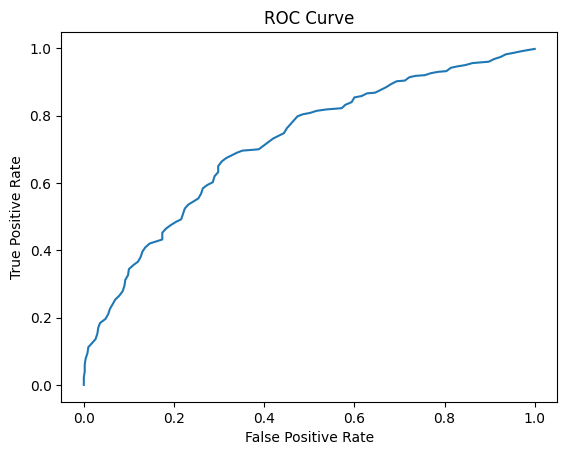

In [15]:
from eval.auroc import get_auroc

auroc = get_auroc(
    ood_detector,
    id_test_dataloader,
    ood_dataloader,
)

In [16]:
print("AUROC:", auroc)



AUROC: 0.7176120281219482


## Visualization

Hover above the bars to see the sample IDs corresponding to the scores. In the next cell, you can input the IDs to hear what the samples sound like.

In [17]:
from eval.graph_viz import get_graph_visualization

fig = get_graph_visualization(
    ood_detector,
    id_test_dataloader,
    ood_dataloader,
)

Hear ID input samples and outputs:

In [18]:
id_input_index = 1
ood_input_index = 1

In [19]:
from utils.convert import sequence_to_wav
from IPython.display import Audio

id_input_sample = id_test_dataloader.dataset[id_input_index]
id_sequence = id_input_sample["input_ids"].tolist()
id_export_filepath = "id_input_sample.wav"
sequence_to_wav(id_sequence, id_export_filepath)

ood_input_sample = ood_dataloader.dataset[ood_input_index]
ood_sequence = ood_input_sample["input_ids"]
ood_export_filepath = "ood_input_sample.wav"
sequence_to_wav(ood_sequence, ood_export_filepath)

Audio(id_export_filepath)




















converting event to compound 120


FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'id_input_sample.wav'..
converting event to compound 120


TypeError: data byte must be int

In [ ]:
Audio(ood_export_filepath)

Hear the outputs from the model:

In [ ]:
from utils.sample import generate_tokens
from constants.token_constants import AR

generate_length = 120

id_output_sample = generate_tokens(
    model,
    [AR],
    id_sequence[1:],
    generate_length,
)

print("output", id_output_sample[len(id_sequence)-1:])

id_export_filepath = "id_ouput_sample.wav"
sequence_to_wav(id_output_sample, id_export_filepath)

Audio(id_export_filepath)



In [ ]:
ood_output_sample = generate_tokens(
    model,
    [AR],
    ood_sequence[1:],
    generate_length,
)

ood_export_filepath = "ood_output_sample.wav"
sequence_to_wav(ood_output_sample, ood_export_filepath)
print("output", ood_output_sample[len(ood_sequence)-1:])

Audio(ood_export_filepath)
